In [1]:
#Load module

import sys
from pathlib import Path, PurePath
import numpy as np
import matplotlib.pyplot as plt

try:
    base_dir.exists()
except NameError:
    curr_dir = Path().resolve()
    base_dir = curr_dir  

data_dir = base_dir / "data" 

import settings as sett

sys.path.append(str(data_dir.absolute()))

import data_loader as dl 


key = ['h', 'u', 'v']
day0 = sett.day0
day1 = sett.day1
days = [day0, day1]
param_list = sett.param_list

Np = len(param_list)

LOAD

In [2]:
## Load mesh and bathymetry

loaded_mesh = np.load(data_dir / Path('shinnecock_domain.npz'), allow_pickle=True)

mesh = loaded_mesh['mesh'].item()
nodes = mesh['nodes']
elems = mesh['triangles']
time = loaded_mesh['time']
bathy = loaded_mesh['bathy']


print(f'Number of Finite Element nodes = {nodes.shape[0]}')

Number of Finite Element nodes = 3070


In [3]:
## Load state vectors for each parameter

variables = {}

for param in param_list:
    loaded_data = np.load(data_dir / Path(f'shinnecock_{param}.npz'), allow_pickle=True)
    variables[param] = {
        'h': loaded_data['h'],
        'u': loaded_data['u'],
        'v': loaded_data['v']
    }

print(f'Number of parametric simulations loaded = {len(param_list)}')

Number of parametric simulations loaded = 7


VISUALIZE

In [4]:
h_test = variables[param_list[0]][key[0]]
u_test = variables[param_list[0]][key[1]]
v_test = variables[param_list[0]][key[2]]


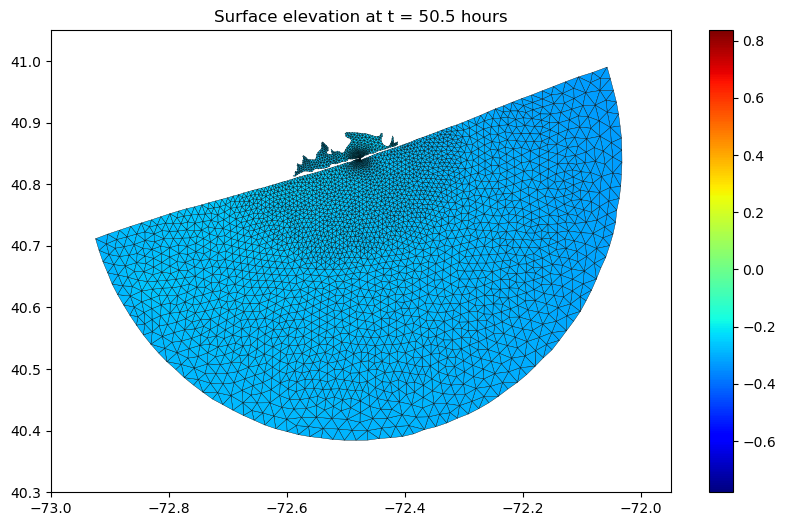

In [5]:
t_index = 100
tn = time[t_index]

field = h_test
valmax = field.max()
valmin = field.min()


fig, axs = plt.subplots(1,1, figsize=(10,6))
im = axs.tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, field[:,t_index],
                      edgecolor='black', cmap = 'jet', vmin = valmin, vmax = valmax, )

axs.set_xlim([-73, -71.95])
axs.set_ylim([40.3,41.05])
fig.colorbar(im)
axs.set_title(f'Surface elevation at t = {tn/3600} hours')

plt.show()

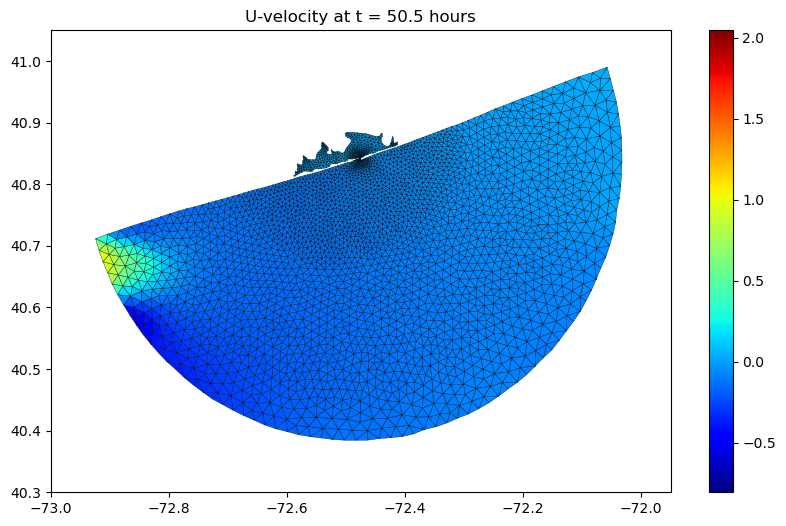

In [6]:

field = u_test
valmax = field.max()
valmin = field.min()

fig, axs = plt.subplots(1,1, figsize=(10,6))
im = axs.tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, field[:,t_index],
                      edgecolor='black', cmap = 'jet', vmin = valmin, vmax = valmax, )

axs.set_xlim([-73, -71.95])
axs.set_ylim([40.3,41.05])
fig.colorbar(im)
axs.set_title(f'U-velocity at t = {tn/3600} hours')

plt.show()

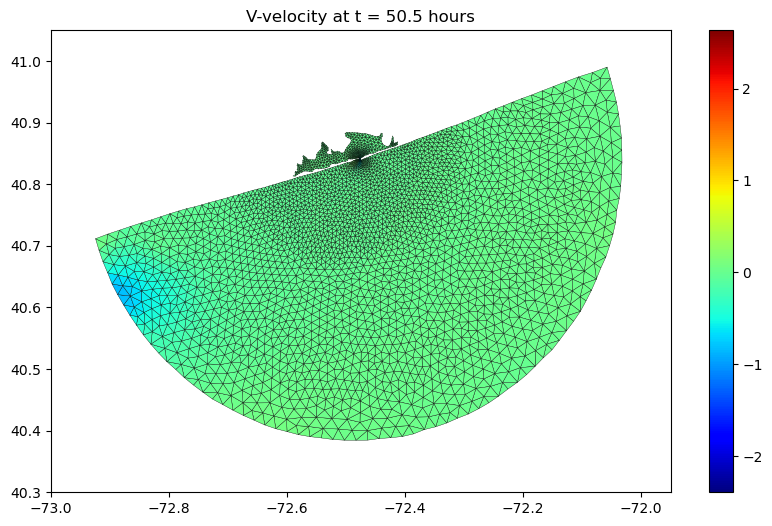

In [7]:
field = v_test
valmax = field.max()
valmin = field.min()

fig, axs = plt.subplots(1,1, figsize=(10,6))
im = axs.tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, field[:,t_index],
                      edgecolor='black', cmap = 'jet', vmin = valmin, vmax = valmax, )

axs.set_xlim([-73, -71.95])
axs.set_ylim([40.3,41.05])
fig.colorbar(im)
axs.set_title(f'V-velocity at t = {tn/3600} hours')

plt.show()

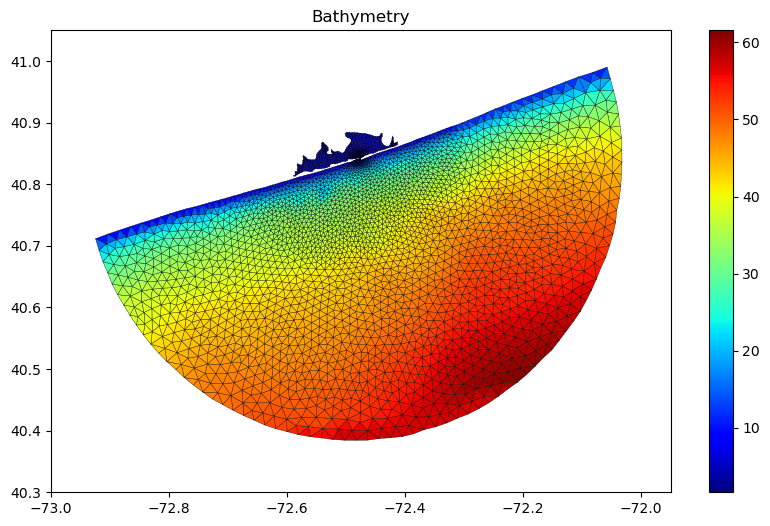

In [8]:
field = bathy
valmax = field.max()
valmin = field.min()

fig, axs = plt.subplots(1,1, figsize=(10,6))
im = axs.tripcolor(nodes[:, 0], nodes[:, 1], elems - 1, field,
                      edgecolor='black', cmap = 'jet', vmin = valmin, vmax = valmax, )

axs.set_xlim([-73, -71.95])
axs.set_ylim([40.3,41.05])
fig.colorbar(im)
axs.set_title(f'Bathymetry')

plt.show()